# Structure-Function Analysis
- Related to Figure 7.
- Visual response is correlated with connectivity.

In [1]:
import numpy as np
import pandas as pd
import pickle

import datajoint as dj

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import pearsonr, percentileofscore

from lib.utils import *
from lib.data import *
from lib.calcium import *
from lib.plot import *
from lib.utils import *

%matplotlib inline

## Load data tables

In [2]:
Neuron = load_dict("data/Neuron.pkl")
Soma = load_dict("data/Soma.pkl")
SynDensity = load_dict("data/SynDensity.pkl")
Stimulus = load_dict("data/Stimulus.pkl")
EASETrace = load_dict("data/EASETrace.pkl")
EASETuning = load_dict("data/EASETuning.pkl")

## All pyramidal cells (PyCs)
- 363 pyramidal cells that have soma inside the volume.

In [3]:
pyc_list = Neuron["segment_id"]
n_pyc = pyc_list.shape[0]

## PyCs with functional data

In [4]:
pyc_func_list = EASETuning["segment_id"]
scan_list = EASETuning["scan_id"]
n_func = pyc_func_list.shape[0]

osi_p = EASETuning["osi_p"]
dsi_p = EASETuning["dsi_p"]

tune_idx = osi_p<0.01

## Soma center coordinates

#### All PyCs

In [5]:
pyc_soma_loc = np.zeros((n_pyc, 3))
for i in range(n_pyc):
    
    seg_id = pyc_list[i]
    pyc_soma_loc[i,:] = get_soma_loc(Soma, seg_id)

#### PyCs with functional data

In [6]:
pyc_func_soma_loc = np.zeros((n_func, 3))
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    idx = np.where(pyc_list==seg_id)[0][0]
    pyc_func_soma_loc[i,:] = pyc_soma_loc[idx,:]

## Compute in-connection density

In [7]:
# In/out density
insyn_density = np.zeros((n_func)) # In-synapse density
inconn_density = np.zeros((n_func)) # In-connection density
outsyn_density = np.zeros((n_func)) # Out-synapse density
outconn_density = np.zeros((n_func)) # Out-connection density
total_insyn_density = np.zeros((n_func)) # Total in-synapse density

for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    
    key = {"segment_id": seg_id}
    outsyn_density[i] = get_density(SynDensity, seg_id, "outsyn_dens")
    insyn_density[i] = get_density(SynDensity, seg_id, "insyn_dens")
    
    outconn_density[i] = get_density(SynDensity, seg_id, "outconn_dens")
    inconn_density[i] = get_density(SynDensity, seg_id, "inconn_dens")
    
    total_insyn_density[i] = get_density(SynDensity, seg_id, "total_insyn_dens")

## Response strength

In [8]:
mean_response = np.zeros(n_func)

for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    scan_id = int(scan_list[pyc_func_list==seg_id])

    trace = get_trace(EASETrace, seg_id, scan_id, "trace_raw")
    stimlab = get_stim_label(Stimulus, scan_id)
    if dsi_p[pyc_func_list==seg_id]<0.01:
        cell_type = "ds"
    else:
        cell_type = "os"
        
    mean_response[i] = compute_response_strength(trace, stimlab, cell_type)

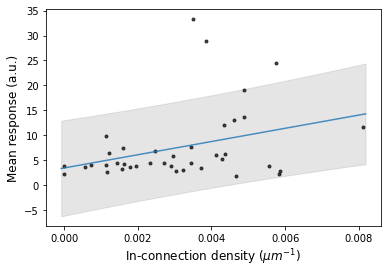

r = 0.33588094408719515, p = 0.03657351904857107


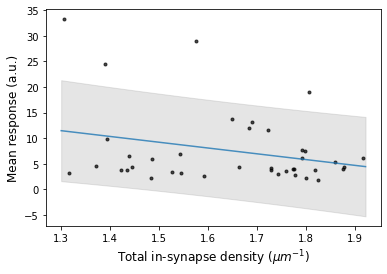

r = -0.27441346360625496, p = 0.09091664877792348


In [9]:
plot_linear_fit(inconn_density[tune_idx], mean_response[tune_idx],
         xlab="In-connection density ($\mu m^{-1}$)",
         ylab="Mean response (a.u.)")

plot_linear_fit(total_insyn_density[tune_idx], mean_response[tune_idx],
         xlab="Total in-synapse density ($\mu m^{-1}$)",
         ylab="Mean response (a.u.)")

## Intermittency

In [13]:
intermittency = np.zeros(n_func)
for i in range(n_func):
    
    seg_id = pyc_func_list[i]
    scan_id = int(scan_list[pyc_func_list==seg_id])

    trace = get_trace(EASETrace, seg_id, scan_id, "trace_raw")
    spike = get_trace(EASETrace, seg_id, scan_id, "spike")
    stimlab = get_stim_label(Stimulus, scan_id)
    
    response_array = get_peakamp_tdarray(trace, stimlab)
    tune = tuning_curve(response_array)
    dir_pref = np.argmax(tune)
    dir_opp = np.remainder(dir_pref+8, 16)
    
    if dsi_p[pyc_func_list==seg_id]<0.01:
        pref_idx = [dir_pref]
    else:
        pref_idx = [dir_pref, dir_opp]
    intermittency[i] = compute_intermittency(spike, stimlab, pref_idx, thr=3)

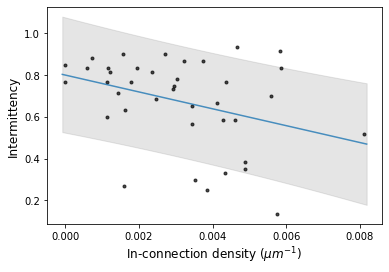

r = -0.3526467029064188, p = 0.027672033952303273


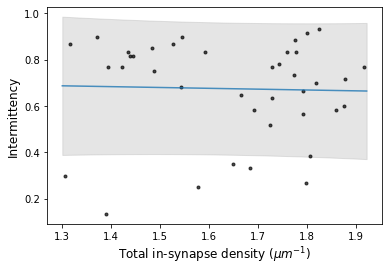

r = -0.030240020253543172, p = 0.8549971406210989


In [14]:
plot_linear_fit(inconn_density[tune_idx], intermittency[tune_idx],
         xlab="In-connection density ($\mu m^{-1}$)",
         ylab="Intermittency")

plot_linear_fit(total_insyn_density[tune_idx], intermittency[tune_idx],
         xlab="Total in-synapse density ($\mu m^{-1}$)",
         ylab="Intermittency")

## OSi / DSi

In [25]:
osi_list = EASETuning["osi"]
dsi_list = EASETuning["dsi"]

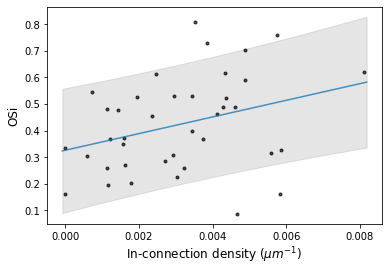

r = 0.32656272429825073, p = 0.0424544791355461


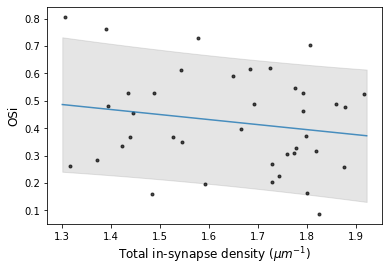

r = -0.18301136867681028, p = 0.2647770342879195


In [26]:
plot_linear_fit(inconn_density[tune_idx], osi_list[tune_idx],
         xlab="In-connection density ($\mu m^{-1}$)",
         ylab="OSi")

plot_linear_fit(total_insyn_density[tune_idx], osi_list[tune_idx],
         xlab="Total in-synapse density ($\mu m^{-1}$)",
         ylab="OSi")

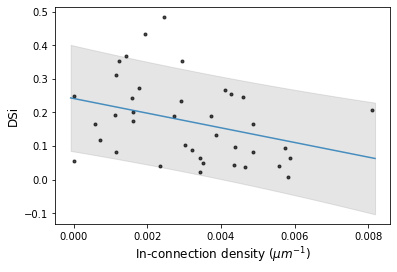

r = -0.3358843386448131, p = 0.03657150476798296


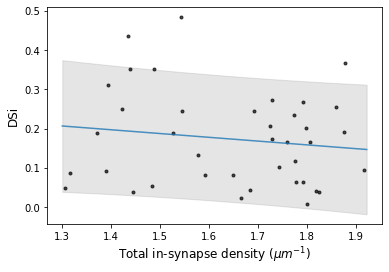

r = -0.14155882599142422, p = 0.3900025447983141


In [27]:
plot_linear_fit(inconn_density[tune_idx], dsi_list[tune_idx],
         xlab="In-connection density ($\mu m^{-1}$)",
         ylab="DSi")

plot_linear_fit(total_insyn_density[tune_idx], dsi_list[tune_idx],
         xlab="Total in-synapse density ($\mu m^{-1}$)",
         ylab="DSi")

## Spatial location restricted permutation test

In [28]:
xloc = pyc_func_soma_loc[tune_idx,0]
yloc = pyc_func_soma_loc[tune_idx,1]
zloc = pyc_func_soma_loc[tune_idx,2]

xbins = np.linspace(np.min(xloc), np.max(xloc)*1.001, 3); nx = xbins.shape[0]-1
ybins = np.linspace(np.min(yloc), np.max(yloc)*1.001, 5); ny = ybins.shape[0]-1
zbins = np.linspace(np.min(zloc), np.max(zloc)*1.001, 3); nz = zbins.shape[0]-1

val_density = inconn_density[tune_idx]
indices = np.arange(val_density.shape[0])

idx_list = []
density_list = []
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            
            valid = (xloc>=xbins[i])*(xloc<xbins[i+1]) \
                    *(yloc>=ybins[j])*(yloc<ybins[j+1]) \
                    *(zloc>=zbins[k])*(zloc<zbins[k+1])
            
            density_bin = val_density[valid]
            
            idx_list.append(indices[valid])
            density_list.append(density_bin)

### Mean response

In [96]:
xval = mean_response[tune_idx]
yval = inconn_density[tune_idx]

T = 10000
rand_resp = np.zeros((T,))

for t in range(T):
    
    density_shuffled = np.copy(xval)
    for j in range(len(idx_list)):
        idx_bin = idx_list[j]
        np.random.shuffle(density_list[j])
        density_shuffled[idx_bin] = density_list[j]
    
    r, p = pearsonr(xval, density_shuffled)
    rand_resp[t] = r

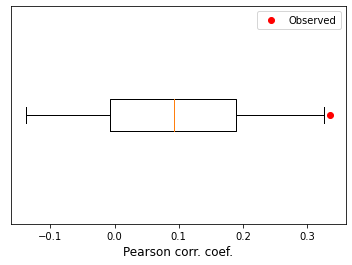

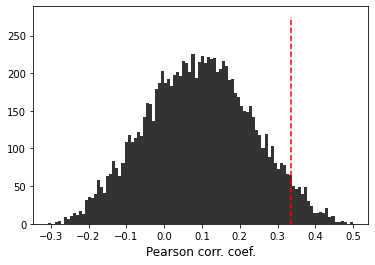

p = 0.04189999999999994


In [97]:
r_true_resp, p_true_resp = pearsonr(inconn_density[tune_idx], mean_response[tune_idx])

plt.figure()
plt.boxplot(rand_resp, sym="", whis=[5,95], vert=False)
plt.plot(r_true_resp, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_resp, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_resp, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(1-percentileofscore(rand_resp, r_true_resp)/100))

### Intermittency

In [98]:
xval = intermittency[tune_idx]
yval = inconn_density[tune_idx]

T = 10000
rand_int = np.zeros((T,))

for t in range(T):
    
    density_shuffled = np.copy(xval)
    for j in range(len(idx_list)):
        idx_bin = idx_list[j]
        np.random.shuffle(density_list[j])
        density_shuffled[idx_bin] = density_list[j]
    
    r, p = pearsonr(xval, density_shuffled)
    rand_int[t] = r

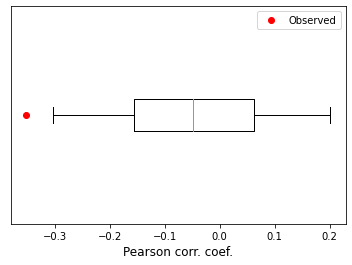

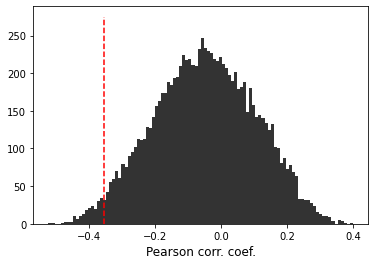

p = 0.0212


In [99]:
r_true_int, p_true_int = pearsonr(inconn_density[tune_idx], intermittency[tune_idx])

plt.figure()
plt.boxplot(rand_int, sym="", whis=[5,95], vert=False)
plt.plot(r_true_int, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_int, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_int, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(percentileofscore(rand_int, r_true_int)/100))

### OSi

In [106]:
xval = osi_list[tune_idx]
yval = inconn_density[tune_idx]

T = 10000
rand_osi = np.zeros((T,))

for t in range(T):
    
    density_shuffled = np.copy(xval)
    for j in range(len(idx_list)):
        idx_bin = idx_list[j]
        np.random.shuffle(density_list[j])
        density_shuffled[idx_bin] = density_list[j]
    
    r, p = pearsonr(xval, density_shuffled)
    rand_osi[t] = r

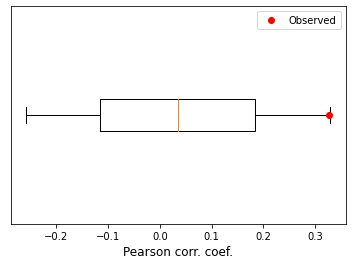

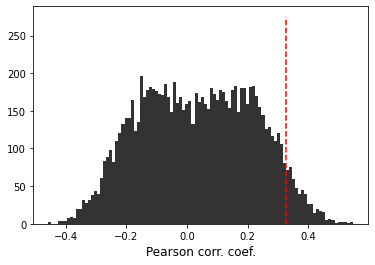

p = 0.05120000000000002


In [107]:
r_true_osi, p_true_osi = pearsonr(inconn_density[tune_idx], osi_list[tune_idx])

plt.figure()
plt.boxplot(rand_int, sym="", whis=[5,95], vert=False)
plt.plot(r_true_int, 1, "r.", markersize=12, label="Observed")
plt.yticks([])
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.legend(loc="upper right")
plt.show()

plt.figure()
plt.hist(rand_int, bins=100, color="k", alpha=0.8)
plt.vlines(r_true_int, 0, 275, linestyle="--", color="r")
plt.xlabel("Pearson corr. coef.", fontsize=12)
plt.show()

print("p = {}".format(1-percentileofscore(rand_osi, r_true_osi)/100))